# Install NLTK and Download Resources

In [1]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Electronica\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Electronica\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import Libraries

In [3]:
import string
import pandas as pd
import numpy as np
import re
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

# Load and Preprocess Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_csv("News Detections_Training Part.csv")

# Cleaning the Dataset

In [5]:
df.drop(columns=['news_reply','news_url','source_domain'],inplace=True)

In [6]:
df

real                                               news
0         1  Kandi Burruss Explodes Over Rape Accusation on...
1         1  People's Choice Awards 2018: The best red carp...
2         1  Sophia Bush Sends Sweet Birthday Message to 'O...
3         1  Colombian singer Maluma sparks rumours of inap...
4         1  Gossip Girl 10 Years Later: How Upper East Sid...
...     ...                                                ...
16994     1    How Amber Rose Became an Unlikely Feminist Icon
16995     0  Rihanna Cradles Newborn Baby in Loving Twitter...
16996     1  Kourtney Kardashian and Younes Bendjima Are Ma...
16997     1  Emmy Awards 2017: Elisabeth Moss found out abo...
16998     0  Jason Aldean Gig Canceled After He Sells Out T...

[16999 rows x 2 columns]

# Handling Duplicated Values

In [7]:
df.duplicated().sum()

817

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.duplicated().sum()

0

In [10]:
df

real                                               news
0         1  Kandi Burruss Explodes Over Rape Accusation on...
1         1  People's Choice Awards 2018: The best red carp...
2         1  Sophia Bush Sends Sweet Birthday Message to 'O...
3         1  Colombian singer Maluma sparks rumours of inap...
4         1  Gossip Girl 10 Years Later: How Upper East Sid...
...     ...                                                ...
16994     1    How Amber Rose Became an Unlikely Feminist Icon
16995     0  Rihanna Cradles Newborn Baby in Loving Twitter...
16996     1  Kourtney Kardashian and Younes Bendjima Are Ma...
16997     1  Emmy Awards 2017: Elisabeth Moss found out abo...
16998     0  Jason Aldean Gig Canceled After He Sells Out T...

[16182 rows x 2 columns]

In [11]:
df.isnull()

real   news
0      False  False
1      False  False
2      False  False
3      False  False
4      False  False
...      ...    ...
16994  False  False
16995  False  False
16996  False  False
16997  False  False
16998  False  False

[16182 rows x 2 columns]

In [12]:
df.isnull().sum()

real    0
news    0
dtype: int64

In [13]:
df.describe()

real
count  16182.000000
mean       0.758126
std        0.428231
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000

## Text Cleaning

In [14]:
STOP_WORDS = set(stopwords.words("english"))
LEMMATIZER = WordNetLemmatizer()

def clean_mentions(text: str):
    return re.sub(r"@[a-zA-Z0-9_]+", "", text)

def clean_URLs(text: str):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

def clean_HTML5_entities(text: str):
    return re.sub(r"&[a-z]+;", "", text)

def clean_punctuations(text: str):
    return re.sub(r"\W", " ", text)

def clean_numbers(text: str):
    return re.sub(r"[0-9]+", "", text)

def clean_stopwords(text: str):
    return " ".join([token for token in text.split() if token not in STOP_WORDS])

def lemmatize_text(text: str):
    return " ".join([LEMMATIZER.lemmatize(token, pos="v") for token in text.split()])

def normalize(text: str):
    text = text.lower()
    text = clean_mentions(text)
    text = clean_URLs(text)
    text = clean_HTML5_entities(text)
    text = clean_punctuations(text)
    text = clean_numbers(text)
    text = clean_stopwords(text)
    text = lemmatize_text(text)
    return text

In [15]:
df["news"] = df["news"].apply(str.lower)
df['news'] = df['news'].apply(clean_URLs)
df['news'] = df['news'].apply(clean_HTML5_entities)
df['news'] = df['news'].apply(clean_numbers)
df['news'] = df['news'].apply(clean_stopwords)
df['news'] = df['news'].apply(clean_punctuations)
df["news"] = df["news"].apply(lemmatize_text)
display(df['news'])

0        kandi burruss explode rape accusation real hou...
1               people s choice award best red carpet look
2        sophia bush send sweet birthday message one tr...
3        colombian singer maluma spark rumour inappropr...
4        gossip girl years later upper east siders shoc...
                               ...                        
16994             amber rise become unlikely feminist icon
16995     rihanna cradle newborn baby love twitter picture
16996    kourtney kardashian younes bendjima make paris...
16997        emmy award elisabeth moss find nomination gif
16998            jason aldean gig cancel sell liberals snl
Name: news, Length: 16182, dtype: object

# TF-IDF Vectorization

In [16]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Max words
tfidf_features = tfidf_vectorizer.fit_transform(df['news'])

# Train-Test Split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_features, df['real'], test_size=0.2, random_state=42)

# Model Definition and Training

In [18]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Prediction and Accuracy

In [19]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.8211306765523633


# Confusion Matrix and Accuracy

Confusion Matrix:
[[ 313  475]
 [ 104 2345]]


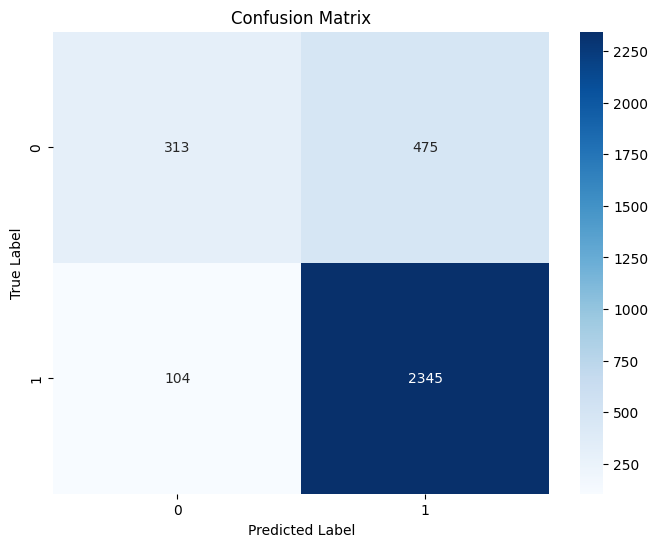

Accuracy: 0.8211306765523633


In [20]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Display Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracy)

# AUC-ROC Curve

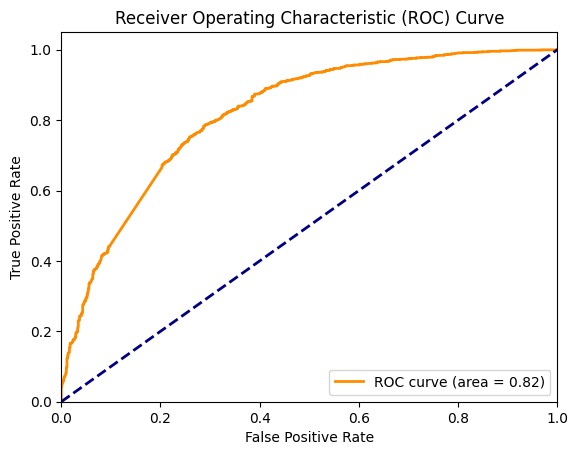

In [22]:
y_probs = model.predict_proba(x_test)[:,1]
auc_roc = roc_auc_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# cross validation

In [24]:
# Cross-Validation
cv_scores = cross_val_score(model, tfidf_features, df['real'], cv=5)  # 5-fold cross-validation
print("Cross-Validation Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Mean Accuracy: 0.8172043121616446


# Grid search

In [25]:
# Grid Search
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(model, param_grid, cv=5, verbose=3)
grid_search.fit(x_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.762 total time=   1.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.762 total time=   1.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.767 total time=   4.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.764 total time=   1.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.762 total time=   1.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.771 total time=   1.9s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.771 total time=   1.9s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.774 total time=   1.9s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.776 total time=   1.9s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.774 to

# Rondom search

In [26]:
# Random Search
param_dist = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}
random_search = RandomizedSearchCV(model, param_dist, cv=5, n_iter=10, random_state=42, verbose=3)
random_search.fit(x_train, y_train)
print("Best Parameters (Random Search):", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.795 total time=  16.6s
[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.793 total time=  17.0s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.796 total time=  17.8s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.790 total time=  18.9s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.795 total time=  16.3s
[CV 1/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.810 total time=   3.6s
[CV 2/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.808 total time=   6.8s
[CV 3/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.810 total time=   3.6s
[CV 4/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.808 total time=   3.5s
[CV 5/5] END learning_rate=0.1, max_depth=5, n_estimators=100;, score=0.811 tot

# Process User Input and Predict

In [23]:
def preprocess_input(text):
    cleaned_text = normalize(text)
    transformed_text = tfidf_vectorizer.transform([cleaned_text]).toarray()
    return transformed_text

def predict_real_or_fake(text):
    transformed_text = preprocess_input(text)
    prediction = model.predict(transformed_text)
    real_or_fake_mapping = {0: 'fake',1:'real'}
    real_or_fake = real_or_fake_mapping[prediction[0]]
    return real_or_fake

## Test with User Input

In [24]:
text="Gwen Stefani Got Dumped by Blake Shelton Over \"Jealousy and Drama\" (EXCLUSIVE)"
real_or_fake = predict_real_or_fake(text)
print(f"Text: '{text}'")
print(f"Predicted Real or Fake: {real_or_fake}\n")


Text: 'Gwen Stefani Got Dumped by Blake Shelton Over "Jealousy and Drama" (EXCLUSIVE)'
Predicted Real or Fake: fake



# save the model

In [26]:
joblib.dump(model, "real_or_fake_model.XG_Boost")

['real_or_fake_model.XG_Boost']